# 1. Importing

In [24]:
# Standard libraries
import logging
import os
import sys
import time
import re

# External libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

# Project specific imports
from CONSTANTS import DEVICE, LOG_ROOT, PROJECT_ROOT, SESSION
from models.gru import AttGRUModel
from module.Common import batch_variable_inst, data_iter, generate_tinsts_binary_label
from module.Optimizer import Optimizer
from preprocessing.AutoLabeling import Probabilistic_Labeling
from preprocessing.datacutter.SimpleCutting import cut_by
from preprocessing.Preprocess import Preprocessor
from representations.sequences.statistics import Sequential_TF
from representations.templates.statistics import (
    Simple_template_TF_IDF,
    Template_TF_IDF_without_clean,
)
from utils.Vocab import Vocab

# 2. Custom default params

## 2.1. Hyper-params

In [25]:
# Define the word2vec file and its dimensions
word2vec_file = "glove.840B.300d.txt"
dim = 300

# Set the hyperparameters
alpha = 0.001  # Learning rate for meta-train
beta = 1       # Scaling factor for meta-test loss
gamma = 0.001  # Learning rate for optimizer

## 2.2. Network model params

In [26]:
# LSTM hidden units
lstm_hiddens = 16

# Number of layers in the network
num_layer = 2

# Batch size for training
batch_size = 100

# Dropout rate
drop_out = 0.1

# Number of training epochs
epochs = 5

# Threshold for prediction
threshold = 0.5

## 2.3. Dataset params

In [27]:
# Define the parser type
parser = "IBM"

# Set the mode to 'train'
mode = "train"

# Parameters for clustering
min_cluster_size = 100
min_samples = 100

# Dimension reduction target
reduce_dimensions = 50

# 3. Saving the model

In [28]:
def get_file_paths(dataset, parser, min_cluster_size, min_samples, project_root):
    """Generate file paths for probabilistic labeling, random state, model, and result directories."""
    save_dir = os.path.join(project_root, "outputs")
    
    prob_label_res_file = os.path.join(
        save_dir,
        f"results/MetaLog/{dataset}_{parser}/prob_label_res/mcs-{min_cluster_size}_ms-{min_samples}"
    )
    rand_state_file = os.path.join(
        save_dir,
        f"results/MetaLog/{dataset}_{parser}/prob_label_res/random_state"
    )
    
    return prob_label_res_file, rand_state_file


# Generate file paths for HDFS (source dataset)
prob_label_res_file_HDFS, rand_state_file_HDFS = get_file_paths("HDFS", parser, min_cluster_size, min_samples, PROJECT_ROOT)

# Generate file paths for BGL (target dataset)
prob_label_res_file_BGL, rand_state_file_BGL = get_file_paths("BGL", parser, min_cluster_size, min_samples, PROJECT_ROOT)

# Shared model and result directories
output_model_dir = os.path.join(PROJECT_ROOT, f"outputs/models/MetaLog/{parser}/model")
output_res_dir = os.path.join(PROJECT_ROOT, f"outputs/results/MetaLog/{parser}/detect_res")

# 4. Function for updating model

In [29]:
def get_updated_network(old, new, lr, load=False):
    updated_theta = {}
    state_dicts = old.state_dict()
    param_dicts = dict(old.named_parameters())

    for i, (k, v) in enumerate(state_dicts.items()):
        if k in param_dicts.keys() and param_dicts[k].grad is not None:
            updated_theta[k] = param_dicts[k] - lr * param_dicts[k].grad
        else:
            updated_theta[k] = state_dicts[k]
    if load:
        new.load_state_dict(updated_theta)
    else:
        new = put_theta(new, updated_theta)
    return new


def put_theta(model, theta):
    def k_param_fn(tmp_model, name=None):
        if len(tmp_model._modules) != 0:
            for k, v in tmp_model._modules.items():
                if name is None:
                    k_param_fn(v, name=str(k))
                else:
                    k_param_fn(v, name=str(name + "." + k))
        else:
            for k, v in tmp_model._parameters.items():
                if not isinstance(v, torch.Tensor):
                    continue
                tmp_model._parameters[k] = theta[str(name + "." + k)]

    k_param_fn(model)
    return model

# 5. Logging

## 5.1. Logging config

In [30]:
# Log setup
logger = logging.getLogger("MetaLog")
logger.setLevel(logging.DEBUG)

# Formatter
formatter = logging.Formatter(
    "%(asctime)s - %(name)s - " + SESSION + " - %(levelname)s: %(message)s"
)

# Console handler
console_handler = logging.StreamHandler(sys.stderr)
console_handler.setLevel(logging.DEBUG)
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# File handler
file_handler = logging.FileHandler(os.path.join(LOG_ROOT, "MetaLog.log"))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Successfully constructed
logger.info(
    f"Logger for MetaLog constructed successfully. Current working directory: {os.getcwd()}. Logs will be written in {LOG_ROOT}."
)

2024-09-20 08:08:39,635 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Logger for MetaLog constructed successfully. Current working directory: /Users/minhthienlongvo/research/MetaLog. Logs will be written in /Users/minhthienlongvo/research/MetaLog/logs.
2024-09-20 08:08:39,635 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Logger for MetaLog constructed successfully. Current working directory: /Users/minhthienlongvo/research/MetaLog. Logs will be written in /Users/minhthienlongvo/research/MetaLog/logs.


## 5.2. Log custom params

In [31]:
logger.info(f"Network parameters:")
logger.info(f"  - LSTM hidden units: {lstm_hiddens}")
logger.info(f"  - Number of layers: {num_layer}")
logger.info(f"  - Dropout rate: {drop_out}")

logger.info(f"Hyperparameters:")
logger.info(f"  - Alpha: {alpha}")
logger.info(f"  - Beta: {beta}")
logger.info(f"  - Gamma: {gamma}")
logger.info(f"  - Word2Vec file: {word2vec_file}")

2024-09-20 08:08:39,641 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Network parameters:
2024-09-20 08:08:39,641 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Network parameters:
2024-09-20 08:08:39,642 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO:   - LSTM hidden units: 16
2024-09-20 08:08:39,642 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO:   - LSTM hidden units: 16
2024-09-20 08:08:39,643 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO:   - Number of layers: 2
2024-09-20 08:08:39,643 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO:   - Number of layers: 2
2024-09-20 08:08:39,644 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO:   - Dropout rate: 0.1
2024-09-20 08:08:39,644 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO:   - Dropout rate: 0.1
2024-09-20 08:08:39,644 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Hyperparameters:
2024-09-20 08:08:39,644 - MetaLog 

# 6. Import dataset

In [32]:
def preprocess_data(dataset, parser, cut_func, template_encoder):
    """Preprocess the data and return train, validation, and test sets."""
    processor = Preprocessor()
    train_data, valid_data, test_data = processor.process(
        dataset=dataset,
        parsing=parser,
        cut_func=cut_func,
        template_encoding=template_encoder.present,
    )
    return train_data, valid_data, test_data, processor


def encode_log_sequences(processor, train_data, test_data=None):
    """Encode log sequences using a sequential encoder and return updated instances."""
    sequential_encoder = Sequential_TF(processor.embedding)
    
    train_reprs = sequential_encoder.present(train_data)
    for index, inst in enumerate(train_data):
        inst.repr = train_reprs[index]
    
    if (test_data is not None):
        test_reprs = sequential_encoder.present(test_data)
        for index, inst in enumerate(test_data):
            inst.repr = test_reprs[index]
            
        return train_data, test_data
    
    return train_data, None


def reduce_dimension(train_data, reduce_dimensions):
    """Perform dimension reduction using FastICA and update the train data."""
    if reduce_dimensions != -1:
        start_time = time.time()
        print(f"Start FastICA, target dimension: {reduce_dimensions}.")
        transformer = FastICA(n_components=reduce_dimensions)
        train_reprs = np.array([inst.repr for inst in train_data])
        train_reprs_transform = transformer.fit_transform(train_reprs)
        for idx, inst in enumerate(train_data):
            inst.repr = train_reprs_transform[idx]
        print(f"Finished at {round(time.time() - start_time, 2)}.")
    return train_data


def probabilistic_labeling(train_data, min_samples, min_cluster_size, prob_label_res_file, rand_state_file):
    """Perform probabilistic labeling and return labeled training data."""
    train_normal = [x for x, inst in enumerate(train_data) if inst.label == "Normal"]
    normal_ids = train_normal[: int(0.5 * len(train_normal))]
    
    label_generator = Probabilistic_Labeling(
        min_samples=min_samples,
        min_clust_size=min_cluster_size,
        res_file=prob_label_res_file,
        rand_state_file=rand_state_file,
    )
    labeled_train_data = label_generator.auto_label(train_data, normal_ids)
    return labeled_train_data

datasets = ["HDFS", "BGL"]
template_encoder = (
    Template_TF_IDF_without_clean(word2vec_file)
)

template_encoder_NC = None
if "NC" in datasets:
    template_encoder_NC = (
        Simple_template_TF_IDF(word2vec_file)
    )

2024-09-20 08:08:39,655 - Statistics_Template_Encoder - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Loading word2vec dict from glove.840B.300d.txt.
2024-09-20 08:08:39,655 - Statistics_Template_Encoder - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Loading word2vec dict.
100%|██████████| 2196017/2196017 [01:05<00:00, 33746.18it/s]


## 6.1. Import BGL dataset

In [10]:
# Define the anomaly rate for BGL dataset
BGL_ANOMALY_RATE = 0.01  # 1% anomaly in BGL train dataset

# Preprocess BGL data with the specified anomaly rate in the train set
cut_func = cut_by(0.3, 0.0, BGL_ANOMALY_RATE)
train_BGL, _, test_BGL, processor_BGL = preprocess_data("BGL", parser, cut_func, template_encoder)

# Encode log sequences for the train and test sets
encoded_train_BGL, encoded_test_BGL = encode_log_sequences(processor_BGL, train_BGL, test_BGL)

# Reduce dimensions of the encoded train set if necessary
reduced_train_BGL = reduce_dimension(encoded_train_BGL, reduce_dimensions)

# Perform probabilistic labeling on the reduced train set
labeled_train_BGL = probabilistic_labeling(reduced_train_BGL, min_samples, min_cluster_size, prob_label_res_file_BGL, rand_state_file_BGL)

# Assign the final train and test sets
final_train_BGL = reduced_train_BGL
final_test_BGL = encoded_test_BGL

2024-09-20 08:10:03,939 - BGLLoader - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Construct self.logger success, current working directory: /Users/minhthienlongvo/research/MetaLog, logs will be written in /Users/minhthienlongvo/research/MetaLog/logs
2024-09-20 08:10:03,939 - BGLLoader - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Construct self.logger success, current working directory: /Users/minhthienlongvo/research/MetaLog, logs will be written in /Users/minhthienlongvo/research/MetaLog/logs
2024-09-20 08:10:03,941 - BGLLoader - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Start load from previous extraction. File path /Users/minhthienlongvo/research/MetaLog/datasets/BGL/raw_log_seqs.txt
2024-09-20 08:10:03,941 - BGLLoader - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Start load from previous extraction. File path /Users/minhthienlongvo/research/MetaLog/datasets/BGL/raw_log_seqs.txt
100%|██████████| 85577/85577 [00:00<00:00, 158821.78it/s]
2024-09-20 08:10:04,654 

## 6.2. Import HDFS dataset

In [11]:
# Define the anomaly rate for HDFS dataset
HDFS_ANOMALY_RATE = 1.0  # 100% anomaly in HDFS train set

# Preprocess HDFS data with the specified anomaly rate in the train set
cut_func = cut_by(0.3, 0.0, HDFS_ANOMALY_RATE)
train_HDFS, _, _, processor_HDFS = preprocess_data("HDFS", parser, cut_func, template_encoder)

# Encode log sequences for the train set
encoded_train_HDFS, _ = encode_log_sequences(processor_HDFS, train_HDFS)

# Reduce dimensions of the encoded train set if necessary
reduced_train_HDFS = reduce_dimension(encoded_train_HDFS, reduce_dimensions)

# No probabilistic labeling for HDFS, use the reduced train set directly
labeled_train_HDFS = reduced_train_HDFS

# Assign the final train set for HDFS
final_train_HDFS = reduced_train_HDFS

2024-09-20 05:49:03,447 - HDFSLoader - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Construct self.logger success, current working directory: /Users/minhthienlongvo/research/MetaLog, logs will be written in /Users/minhthienlongvo/research/MetaLog/logs
2024-09-20 05:49:03,447 - HDFSLoader - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Start load from previous extraction. File path /Users/minhthienlongvo/research/MetaLog/datasets/HDFS/raw_log_seqs.txt
100%|██████████| 575061/575061 [00:01<00:00, 313247.66it/s]
2024-09-20 05:49:05,355 - HDFSLoader - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Extraction finished successfully.
2024-09-20 05:49:05,570 - drain - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Construct DrainLogger success, current working directory: /Users/minhthienlongvo/research/MetaLog, logs will be written in /Users/minhthienlongvo/research/MetaLog/logs
2024-09-20 05:49:05,570 - drain - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Construct DrainLogger 

Start FastICA, target dimension: 50.
Finished at 19.42.


/Users/minhthienlongvo/research/MetaLog/.venv/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


## 6.3. Aggregate vocabulary

In [12]:
def load_embeddings(processor):
    """Load embeddings from the given processor and return a Vocab object."""
    vocab = Vocab()
    vocab.load_from_dict(processor.embedding)
    return vocab

def merge_embeddings(processor_BGL, processor_HDFS):
    """Merge embeddings from BGL and HDFS processors, handling padding."""
    new_embedding = processor_BGL.embedding.copy()
    padding_offset = len(processor_BGL.embedding)  # Use the length of BGL embedding as padding offset
    logger.info(f"Padding offset: {padding_offset}")
    for key, value in processor_HDFS.embedding.items():
        new_key = key + padding_offset  # Append padding offset to key to avoid conflicts
        new_embedding[new_key] = value
    
    return new_embedding

# Load embeddings for BGL and HDFS
vocab_BGL = load_embeddings(processor_BGL)
vocab_HDFS = load_embeddings(processor_HDFS)

# Merge embeddings from BGL and HDFS
merged_embedding = merge_embeddings(processor_BGL, processor_HDFS)

# Load merged embeddings into a new vocab object
vocab = Vocab()
vocab.load_from_dict(merged_embedding)

2024-09-20 05:49:36,430 - Vocab - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Total words: 436
2024-09-20 05:49:36,432 - Vocab - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: The dim of pretrained embeddings: 300
2024-09-20 05:49:36,433 - Vocab - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Total words: 50
2024-09-20 05:49:36,434 - Vocab - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: The dim of pretrained embeddings: 300
2024-09-20 05:49:36,434 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Padding offset: 432
2024-09-20 05:49:36,435 - Vocab - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Total words: 482
2024-09-20 05:49:36,436 - Vocab - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: The dim of pretrained embeddings: 300


# 7. Training

## 7.1. MetaLog class

In [13]:
class MetaLog:
    def __init__(self, vocab, num_layer, hidden_size, drop_out, label2id):
        # Initialize MetaLog with given parameters
        self.label2id = label2id
        self.vocab = vocab
        self.num_layer = num_layer
        self.hidden_size = hidden_size
        self.batch_size = 128
        self.test_batch_size = 1024
        self.drop_out = drop_out
        
        # Initialize the main and backup models
        self.model = AttGRUModel(vocab, num_layer, hidden_size, drop_out)
        self.bk_model = AttGRUModel(vocab, num_layer, hidden_size, drop_out, is_backup=True)
        
        # Move models to GPU if available
        if torch.cuda.is_available():
            self.model = self.model.cuda(DEVICE)
            self.bk_model = self.bk_model.cuda(DEVICE)
        elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
            self.model = self.model.to(DEVICE)
            self.bk_model = self.bk_model.to(DEVICE)
        
        # Define the loss function
        self.loss = nn.BCELoss()

    def forward(self, inputs, targets):
        # Forward pass through the main model
        tag_logits = self.model(inputs)
        tag_logits = F.softmax(tag_logits, dim=1)
        loss = self.loss(tag_logits, targets)
        return loss

    def bk_forward(self, inputs, targets):
        # Forward pass through the backup model
        tag_logits = self.bk_model(inputs)
        tag_logits = F.softmax(tag_logits, dim=1)
        loss = self.loss(tag_logits, targets)
        return loss

    def predict(self, inputs, threshold=None):
        # Predict tags for given inputs
        with torch.no_grad():
            tag_logits = self.model(inputs)
            tag_logits = F.softmax(tag_logits, dim=1)
        
        if threshold is not None:
            # Apply threshold to determine anomalous tags
            probs = tag_logits.detach().cpu().numpy()
            anomaly_id = self.label2id["Anomalous"]
            pred_tags = np.zeros(probs.shape[0])
            
            for i, logits in enumerate(probs):
                if logits[anomaly_id] >= threshold:
                    pred_tags[i] = anomaly_id
                else:
                    pred_tags[i] = 1 - anomaly_id
        else:
            # Use max value to determine tags
            pred_tags = tag_logits.detach().max(1)[1].cpu()
        
        return pred_tags, tag_logits

    def evaluate(self, dataset, instances, threshold=0.5):
        # Evaluate the model on the given dataset
        logger.info(f"Start evaluating {dataset} by threshold {threshold}")
        
        with torch.no_grad():
            self.model.eval()
            globalBatchNum = 0
            TP, TN, FP, FN = 0, 0, 0, 0
            tag_correct, tag_total = 0, 0
            
            for onebatch in data_iter(instances, self.test_batch_size, False):
                tinst = generate_tinsts_binary_label(onebatch, vocab_BGL, False)
                
                if torch.cuda.is_available():
                    tinst.to_cuda(DEVICE)
                elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
                    tinst.to_mps(DEVICE)
                
                pred_tags, tag_logits = self.predict(tinst.inputs, threshold)
                
                for inst, bmatch in batch_variable_inst(onebatch, pred_tags, tag_logits, processor_BGL.id2tag):
                    tag_total += 1
                    if bmatch:
                        tag_correct += 1
                        if inst.label == "Normal":
                            TN += 1
                        else:
                            TP += 1
                    else:
                        if inst.label == "Normal":
                            FP += 1
                        else:
                            FN += 1
                
                globalBatchNum += 1
            
            if TP + FP != 0:
                # Calculate precision, recall, and F1 score
                precision = 100 * TP / (TP + FP)
                recall = 100 * TP / (TP + FN)
                f1_score = 2 * precision * recall / (precision + recall)
                logger.info(f"{dataset}: F1 score = {f1_score} | Precision = {precision} | Recall = {recall}")
            else:
                logger.info(f"{dataset}: F1 score = {0} | Precision = {0} | Recall = {0}")
                precision, recall, f1_score = 0, 0, 0
        
        return precision, recall, f1_score

# Instantiate the MetaLog class with given parameters
metalog = MetaLog(
    vocab=vocab,
    num_layer=num_layer,
    hidden_size=lstm_hiddens,
    drop_out=drop_out,
    label2id=processor_BGL.label2id,
)

2024-09-20 05:49:36,465 - AttGRU - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: ==== Model Parameters ====
2024-09-20 05:49:36,466 - AttGRU - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Input Dimension: 300
2024-09-20 05:49:36,466 - AttGRU - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Hidden Size: 16
2024-09-20 05:49:36,466 - AttGRU - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Num Layers: 2
2024-09-20 05:49:36,467 - AttGRU - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Dropout: 0.1


2 32
Orthogonal pretrainer loss: 3.10e-04
2 32
Orthogonal pretrainer loss: 1.66e-03


# 7.2. Model saving

In [14]:
"""Create the model output directory if it doesn't exist."""
if not os.path.exists(output_model_dir):
    os.makedirs(output_model_dir)

"""Construct and return the paths for the best and last model files."""
info = f"layer={num_layer}_hidden={lstm_hiddens}_dropout_{drop_out}_epoch={epochs}"

best_model_file = os.path.join(output_model_dir, info + "_best.pt")
last_model_file = os.path.join(output_model_dir, info + "_last.pt")

## 7.3. Training

In [15]:
if mode == "train":
    # Initialize optimizer
    optimizer = Optimizer(
        filter(lambda p: p.requires_grad, metalog.model.parameters()), lr=gamma
    )
    global_step = 0
    best_f1_score = 0

    for epoch in range(epochs):
        metalog.model.train()
        metalog.bk_model.train()
        start_time = time.strftime("%H:%M:%S")
        logger.info(
            f"Starting epoch: {epoch} | phase: train | start time: {start_time} | learning rate: {optimizer.lr}."
        )

        batch_num_train = int(np.ceil(len(labeled_train_HDFS) / float(batch_size)))
        batch_num_test = int(np.ceil(len(labeled_train_BGL) / float(batch_size)))
        total_batches = max(batch_num_train, batch_num_test)

        meta_train_loader = data_iter(labeled_train_HDFS, batch_size, True)
        meta_test_loader = data_iter(labeled_train_BGL, batch_size, True)

        for _ in range(total_batches):
            optimizer.zero_grad()

            # Meta-train on HDFS
            try:
                meta_train_batch = next(meta_train_loader)
            except StopIteration:
                meta_train_batch = data_iter(labeled_train_BGL, batch_size, True)
                meta_train_batch = next(meta_train_loader)
                
            tinst_train = generate_tinsts_binary_label(meta_train_batch, vocab)
            if torch.cuda.is_available():
                tinst_train.to_cuda(DEVICE)
            elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
                tinst_train.to_mps(DEVICE)
            train_loss = metalog.forward(tinst_train.inputs, tinst_train.targets)
            train_loss_value = train_loss.data.cpu().numpy()
            train_loss.backward(retain_graph=True)

            # Update backup model
            if torch.cuda.is_available():
                metalog.bk_model = (
                    get_updated_network(metalog.model, metalog.bk_model, alpha)
                    .train()
                    .cuda()
                )
            elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
                metalog.bk_model = (
                    get_updated_network(metalog.model, metalog.bk_model, alpha)
                    .train()
                    .to(DEVICE)
                )
            else:
                metalog.bk_model = get_updated_network(
                    metalog.model, metalog.bk_model, alpha
                ).train()

            # Meta-test on BGL
            try:
                meta_test_batch = next(meta_test_loader)
            except StopIteration:
                meta_test_loader = data_iter(labeled_train_BGL, batch_size, True)
                meta_test_batch = next(meta_test_loader)
                
            tinst_test = generate_tinsts_binary_label(meta_test_batch, vocab_BGL)
            if torch.cuda.is_available():
                tinst_test.to_cuda(DEVICE)
            elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
                tinst_test.to_mps(DEVICE)
            test_loss = beta * metalog.bk_forward(tinst_test.inputs, tinst_test.targets)
            test_loss_value = test_loss.data.cpu().numpy() / beta
            test_loss.backward()

            # Update the model
            optimizer.step()
            global_step += 1

            if global_step % 10 == 0:
                logger.info(
                    f"Step: {global_step} | Epoch: {epoch} | Meta-train loss: {train_loss_value} | Meta-test loss: {test_loss_value}."
                )

        # Evaluate and save the model
        if final_train_BGL and final_train_HDFS:
            metalog.evaluate("Train", final_train_BGL + final_train_HDFS)

        if final_test_BGL:
            _, _, f1_score = metalog.evaluate("Test", final_test_BGL)
            if f1_score > best_f1_score:
                logger.info(
                    f"Exceed best F1 score: history = {best_f1_score}, current = {f1_score}."
                )
                torch.save(metalog.model.state_dict(), best_model_file)
                best_f1_score = f1_score

        logger.info(f"Training epoch {epoch} finished.")
        torch.save(metalog.model.state_dict(), last_model_file)


2024-09-20 05:49:37,054 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Starting epoch: 0 | phase: train | start time: 05:49:37 | learning rate: [0.002].
/Users/minhthienlongvo/research/MetaLog/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:935: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  param_grad = param.grad
2024-09-20 05:49:45,434 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: Step: 10 | Epoch: 0 | Meta-train loss: 0.12690220773220062 | Meta-test l

# 8. Evaluate

In [16]:
# Check if the last model file exists and evaluate it
if os.path.exists(last_model_file):
    logger.info("=== Evaluating Final Model ===")
    metalog.model.load_state_dict(torch.load(last_model_file))
    metalog.evaluate("Final Model on Test BGL", final_test_BGL)

# Check if the best model file exists and evaluate it
if os.path.exists(best_model_file):
    logger.info("=== Evaluating Best Model ===")
    metalog.model.load_state_dict(torch.load(best_model_file))
    metalog.evaluate("Best Model on Test BGL", final_test_BGL)

logger.info("All evaluations finished!")

2024-09-20 07:32:31,701 - MetaLog - SESSION_58270e085650f50865ed3e3fc2588da4 - INFO: === Evaluating Final Model ===
/var/folders/45/0lfy6jf14g3cptljv3x_x53r0000gn/T/ipykernel_91630/658566474.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an i

# 9. Export to graph

## 9.1. Constanst

In [17]:
STATISTICS_TEMPLATE_LOG_PATH = "logs/Statistics_Template.log"
METALOG_LOG_PATH = "logs/MetaLog.log"
LOSS_EPS = 0.05

## 9.2. Extracting

In [21]:
def extract_word2vec_file(log_path, session):
    """Extract the word2vec file path from the statistics template log."""
    with open(log_path, "r") as file:
        for line in file:
            match = re.search(rf"^.+ - Statistics_Template_Encoder - {session} - INFO: Loading word2vec dict from (.+)\.$", line)
            if match:
                return match.group(1)

def extract_f1_scores(log_path, session):
    """Extract train and test F1 scores from the MetaLog."""
    train_f1_scores, test_f1_scores = [], []
    with open(log_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            train_match = re.search(rf"^.+ - MetaLog - {session} - INFO: Train: F1 score = (.+) \| Precision = (.+) \| Recall = (.+)$", line)
            test_match = re.search(rf"^.+ - MetaLog - {session} - INFO: Test: F1 score = (.+) \| Precision = (.+) \| Recall = (.+)$", line)

            if train_match:
                train_f1_scores.append(float(train_match.group(1)))
            if test_match:
                test_f1_scores.append(float(test_match.group(1)))
    return train_f1_scores, test_f1_scores

def extract_meta_losses(log_path, session):
    """Extract meta-train and meta-test losses from the MetaLog."""
    meta_train_losses, meta_test_losses = [], []
    with open(log_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            match = re.search(rf"^.* - MetaLog - {session} - INFO: Step: (.+) \| Epoch: (.+) \| Meta-train loss: (.+) \| Meta-test loss: (.+)\.$", line)
            if match:
                meta_train_losses.append(float(match.group(3)))
                meta_test_losses.append(float(match.group(4)))

    return meta_train_losses, meta_test_losses

# Extract the word2vec file path
word2vec_file = extract_word2vec_file(STATISTICS_TEMPLATE_LOG_PATH, SESSION)
title = f"BILATERAL GENERALIZATION TRANSFERRING HDFS TO BGL USING {word2vec_file}"

# Extract F1 scores and losses
train_f1_scores, test_f1_scores = extract_f1_scores(METALOG_LOG_PATH, SESSION)
meta_train_losses, meta_test_losses = extract_meta_losses(METALOG_LOG_PATH, SESSION)

## 9.3. Plotting

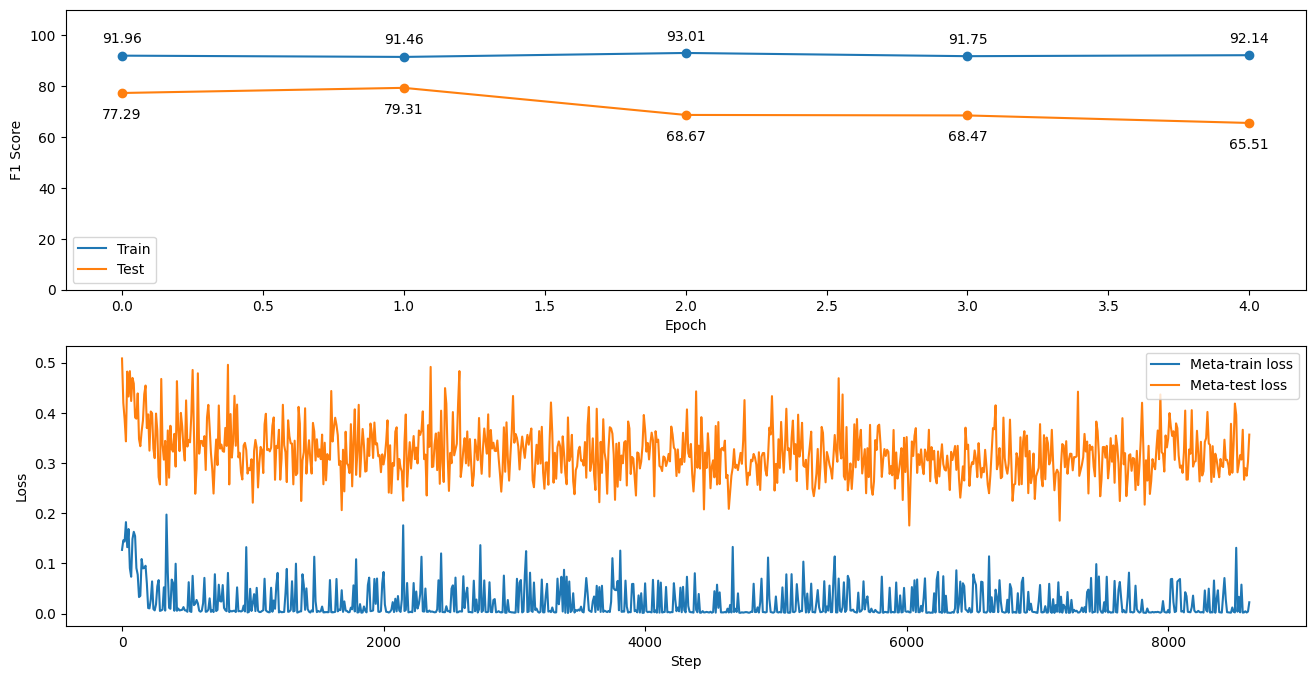

In [22]:
def plot_f1_scores(ax, num_epochs, train_f1, test_f1):
    """Plot train and test F1 scores on the provided axis."""
    ax.set_ylim(0, 110)
    ax.plot(num_epochs, train_f1, color="tab:blue")
    ax.plot(num_epochs, test_f1, color="tab:orange")
    ax.legend(["Train", "Test"])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("F1 Score")

    for i in range(len(num_epochs)):
        ax.plot(num_epochs[i], train_f1[i], "o", color="tab:blue", zorder=10)
        ax.text(num_epochs[i], train_f1[i] + 5, round(train_f1[i], 2), ha="center")

        ax.plot(num_epochs[i], test_f1[i], "o", color="tab:orange", zorder=10)
        ax.text(num_epochs[i], test_f1[i] - 10, round(test_f1[i], 2), ha="center")

def plot_meta_losses(ax, num_steps, meta_train_losses, meta_test_losses):
    """Plot meta-train and meta-test losses on the provided axis."""
    ax.plot(num_steps, meta_train_losses, color="tab:blue")
    ax.plot(num_steps, meta_test_losses, color="tab:orange")
    ax.legend(["Meta-train loss", "Meta-test loss"])
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    
# Plot F1 scores and losses
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
num_epochs = list(range(len(train_f1_scores)))
num_steps = [i * 10 for i in range(len(meta_train_losses))]

plot_f1_scores(axs[0], num_epochs, train_f1_scores, test_f1_scores)
plot_meta_losses(axs[1], num_steps, meta_train_losses, meta_test_losses)

## 9.4. Saving and exporting

In [23]:
# Set the title for the plot
best_test_f1_score = max(test_f1_scores)
fig_title = f"{title}\nBest model F1 Score = {best_test_f1_score}\nLSTM hidden units = {lstm_hiddens} | Layers = {num_layer} | Drop out = {drop_out} | Alpha = {alpha} | Beta = {beta} | Gamma = {gamma}"
fig.suptitle(fig_title)

# Define the path to save the plot
plot_dir = os.path.join("visualization", "graphs")
plot_filename = f"{word2vec_file}-{SESSION}.png"
plot_path = os.path.join(plot_dir, plot_filename)

# Ensure the directory exists
os.makedirs(plot_dir, exist_ok=True)

# Save the plot
fig.savefig(plot_path)